In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import os
from math import sqrt

# TensorFlow related imports
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, RNN, SimpleRNN

# Check TensorFlow version (optional)
#print("TensorFlow version:", tf.__version__)
#print("Numpy version:", np.__version__)

# Scikit-learn and Scikeras for model tuning (if used)
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV

#Let's Examine Correlation between the series
###https://github.com/mikekeith52/scalecast-examples/blob/main/multivariate/multivariate.ipynb

#!pip install scalecast
from scalecast.Forecaster import Forecaster
#from scalecast.MVForecaster import MVForecaster
from scalecast.multiseries import export_model_summaries
from scalecast import GridGenerator
import useful_functions as uf
from statsmodels.tsa.stattools import adfuller, acf

In [45]:
# Change to your file path


# load the data
file_path = '../data/data_orig_parameters.csv'
#file_path = '../data/BR_param_EDA.csv'
#file_path = '../data/data_cleaned_RF.csv'
#file_path = '../data/data_cleaned_LASSO.csv'
#file_path = '../data/data_cleaned_RFE.csv'
# parse the date column and set it as the index of the dataframe
df_raw = pd.read_csv(file_path, parse_dates=['Date'], index_col='Date')
# define the target variable as the first column
target_variable = df_raw.columns[0]
# Convert all columns to float
df_raw = df_raw.astype('float64')

# Remove outliers? Define the threshold from 0 to 1 - float
remove_outliers_threshold = np.nan
#remove_outliers_threshold = 0.20

In [ ]:
# Check if there is any NA value
print(df_raw.isna().sum())

# If we want to remove outliers
if not pd.isna(remove_outliers_threshold):
    df_to_be_cleaned = df_raw.copy()
    df_cleaned = uf.remove_outliers(df_to_be_cleaned, threshold=remove_outliers_threshold)
else:
    df_cleaned = df_raw.copy()

In [ ]:
# Check if there is any NA value
print(df_cleaned.isna().sum())
df_adjusted = uf.fill_missing_values(df_cleaned)

In [ ]:
# Check if there is any collum with unique values and drop it
for column in df_adjusted.columns:
    if len(df_adjusted[column].unique()) == 1:
        df_adjusted.drop(column, axis=1, inplace=True)

print(df_adjusted.shape)

In [53]:
# Test for stationarity and difference the variables if needed
differentiated_df, diff_dict_to_reverse = uf.test_stationarity_and_differenciate(df_adjusted.copy())
differentiated_df = uf.fill_missing_values(differentiated_df)

In [ ]:
print(differentiated_df.shape)

In [ ]:
# Define test and validation set sizes
test_size = 48 # 48 months or 4 years

# Split the data into train and test sets

train_raw = differentiated_df[:-test_size] # This total trainning set will be used to train the final model
test_raw = differentiated_df[-test_size:]

In [ ]:
# Let´s scale the dfs

scaler = MinMaxScaler(feature_range=(0,1))
scaled_train = scaler.fit_transform(train_raw)
scaled_test = scaler.transform(test_raw)
# include df columns names in the train and test sets
train = pd.DataFrame(scaled_train, columns=df_adjusted.columns)
test = pd.DataFrame(scaled_test, columns=df_adjusted.columns)
# Include the index in the train and test sets
train.index = df_adjusted.index[:-test_size]
test.index = df_adjusted.index[-test_size:]

In [82]:
#Get the original and future data sets
forecast_period = 24 # months

#df = differentiated_df.copy()

# Fill missing values with the value from previous observation

differentiated_df = uf.fill_missing_values(differentiated_df)

#Get the original and future data sets 
df_regular = differentiated_df[:-forecast_period].copy()
df_test = differentiated_df[-forecast_period:].copy()

# set the index
#df_ori = df_ori.set_index('date')
#df_months_future = df_months_future.set_index('date')

# Delete the last 30 results to predict it using the model in the future
df_test.loc[:, target_variable] = np.nan


C:\Users\augus\AppData\Local\Temp\ipykernel_20644\1464790299.py:19: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_test.loc[:, target_variable] = np.nan


In [83]:
# Check if there are NAs on trainX, trainY, valX, valY
print("NAs on trainX: ", np.isnan(df_regular).sum())
#print("NAs on trainY: ", np.isnan(df_test).sum())


NAs on trainX:  ECO_fiscal_result_month        0
ECO_fiscal_result_12months     0
ECO_inflation_month            0
ECO_inflation_12months         0
ECO_interest_rate              0
                              ..
IBOV_synthet_roll_mean_12      0
IBOV_synthet_roll_std_12       0
IBOV_synthet_lag_12            0
IBOV_synthet_roll_mean_12.1    0
IBOV_synthet_roll_std_12.1     0
Length: 504, dtype: int64


In [84]:
#Split the dataframe into train and validation sets
#test_split= period_to_test #months
#split_rate = 48 # 6 years
split_rate = 48 # 6 years
df_for_training = df_regular[:-split_rate]
df_for_validation = df_regular[-split_rate:]

In [85]:
# If there are NAs on df_for_training, show me the variable and the rows
print("NAs on df_for_training: ", df_for_training.isna().sum())

NAs on df_for_training:  ECO_fiscal_result_month        0
ECO_fiscal_result_12months     0
ECO_inflation_month            0
ECO_inflation_12months         0
ECO_interest_rate              0
                              ..
IBOV_synthet_roll_mean_12      0
IBOV_synthet_roll_std_12       0
IBOV_synthet_lag_12            0
IBOV_synthet_roll_mean_12.1    0
IBOV_synthet_roll_std_12.1     0
Length: 504, dtype: int64


In [86]:
print(df_for_training.shape)
print(df_for_validation.shape)

(203, 504)
(48, 504)


In [87]:
# Let´s scale the dfs
scaler = MinMaxScaler(feature_range=(0,1))
df_for_training_scaled = scaler.fit_transform(df_for_training)
df_for_validation_scaled=scaler.transform(df_for_validation)
#df_for_test_scaled = scaler.transform(df_test)

In [88]:
# Check if any of the variables contains NAs on scaled dfs
print("NAs on df_for_training_scaled: ", np.isnan(df_for_training).sum())
print("NAs on df_for_validation_scaled: ", np.isnan(df_for_validation).sum())


NAs on df_for_training_scaled:  ECO_fiscal_result_month        0
ECO_fiscal_result_12months     0
ECO_inflation_month            0
ECO_inflation_12months         0
ECO_interest_rate              0
                              ..
IBOV_synthet_roll_mean_12      0
IBOV_synthet_roll_std_12       0
IBOV_synthet_lag_12            0
IBOV_synthet_roll_mean_12.1    0
IBOV_synthet_roll_std_12.1     0
Length: 504, dtype: int64
NAs on df_for_validation_scaled:  ECO_fiscal_result_month        0
ECO_fiscal_result_12months     0
ECO_inflation_month            0
ECO_inflation_12months         0
ECO_interest_rate              0
                              ..
IBOV_synthet_roll_mean_12      0
IBOV_synthet_roll_std_12       0
IBOV_synthet_lag_12            0
IBOV_synthet_roll_mean_12.1    0
IBOV_synthet_roll_std_12.1     0
Length: 504, dtype: int64


In [89]:
# Converting the series to samples

def createXY(dataset,n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            dataX.append(dataset[i - n_past:i, 0:dataset.shape[1]])
            dataY.append(dataset[i,0])
    return np.array(dataX),np.array(dataY)

n_past = 24 # using the last 24 months to predict the next month
trainX,trainY=createXY(df_for_training_scaled,n_past) #using the last 24 months to predict the next month
valX,valY=createXY(df_for_validation_scaled,n_past) #using the last 24 months to predict the next month

# Define the test X as all variables from df_for_test_scaled but the target variable
#testX = df_for_test_scaled[:, 1:]
#testY = df_for_test_scaled[:, 0:1]


In [90]:
print("trainX Shape-- ",trainX.shape)
print("trainY Shape-- ",trainY.shape)
print("ValX Shape-- ",valX.shape)
print("ValY Shape-- ",valY.shape)
#print("testX Shape-- ",testX.shape)
#print("testY Shape-- ",testY.shape)

trainX Shape--  (179, 24, 504)
trainY Shape--  (179,)
ValX Shape--  (24, 24, 504)
ValY Shape--  (24,)


In [91]:
# Check if there are NAs on trainX, trainY, valX, valY
print("NAs on trainX: ", np.isnan(trainX).sum())
print("NAs on trainY: ", np.isnan(trainY).sum())
print("NAs on valX: ", np.isnan(valX).sum())
print("NAs on valY: ", np.isnan(valY).sum())

NAs on trainX:  0
NAs on trainY:  0
NAs on valX:  0
NAs on valY:  0


In [61]:
#Let´s evaluate the parameters for an RNN

# def build_model(optimizer='adam'):
#     grid_model = Sequential()
#     grid_model.add(SimpleRNN(500, return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
#     grid_model.add(SimpleRNN(500))
#     grid_model.add(Dropout(0.10))
#     grid_model.add(Dense(1))

#     grid_model.compile(loss='mse', optimizer=optimizer)
#     return grid_model

# grid_model = KerasRegressor(model=build_model, verbose=0)
# parameters = {'batch_size': [16, 32, 64, 72],
#               'epochs': [15, 20, 25, 30],
#               'optimizer': ['adam', 'Adadelta']}

# grid_search = GridSearchCV(estimator=grid_model,
#                            param_grid=parameters,
#                            cv=2)

# def build_model(optimizer='adam', rnn_nodes=500, dropout_rate=0.1):
#     model = Sequential()
#     model.add(SimpleRNN(rnn_nodes, return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
#     model.add(SimpleRNN(rnn_nodes))
#     model.add(Dropout(dropout_rate))
#     model.add(Dense(1))
#     model.compile(loss='mse', optimizer=optimizer)
#     return model

# # Atualize o KerasRegressor para usar a função build_model atualizada
# grid_model = KerasRegressor(build_fn=build_model, verbose=0)

# # Atualize o dicionário de parâmetros para incluir os novos parâmetros
# parameters = {'batch_size': [16, 32, 64, 72],
#               'epochs': [15, 20, 25, 30],
#               'optimizer': ['adam', 'Adadelta'],
#               'rnn_nodes': [100, 200, 500],
#               'dropout_rate': [0.1, 0.2, 0.3]}

# # Configure o GridSearchCV com o modelo e parâmetros atualizados
# grid_search = GridSearchCV(estimator=grid_model, param_grid=parameters, cv=2)

# print('GridSearchCV configurado com sucesso com parâmetros personalizados.')






In [92]:
import optuna
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Dropout
from keras.optimizers import Adam, Adadelta
#from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
import numpy as np

# Supondo que X_train e y_train já estejam definidos

def create_model(n_units, dropout_rate, optimizer_choice):
    model = Sequential()
    model.add(SimpleRNN(n_units, input_shape=(trainX.shape[1], trainX.shape[2])))
    #model.add(SimpleRNN(n_units, return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
    #model.add(SimpleRNN(n_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='linear'))  # Saída para regressão
    if optimizer_choice == 'adam':
        optimizer = Adam()
    else:
        optimizer = Adadelta()
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

def objective(trial):
    n_units = trial.suggest_categorical('n_units', [10, 20, 50, 100, 200])
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5)
    optimizer_choice = trial.suggest_categorical('optimizer', ['adam', 'Adadelta'])
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128])
    epochs = trial.suggest_categorical('epochs', [15, 20, 25, 30])
    
    model = KerasRegressor(build_fn=create_model, 
                           n_units=n_units, 
                           dropout_rate=dropout_rate, 
                           optimizer_choice=optimizer_choice, 
                           epochs=epochs, 
                           batch_size=batch_size, verbose=0)
    score = -cross_val_score(model, trainX, trainY, n_jobs=-1, cv=2, scoring='neg_mean_squared_error').mean()
    return score

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=150)

print('Número de experimentos concluídos:', len(study.trials))
print('Melhor hiperparâmetros:', study.best_trial.params)

[I 2024-03-07 13:37:29,689] A new study created in memory with name: no-name-be16740b-8c42-41fc-b9b8-1242620fc35b
[I 2024-03-07 13:38:10,969] Trial 0 finished with value: 0.07446364313364029 and parameters: {'n_units': 100, 'dropout_rate': 0.2972342389451085, 'optimizer': 'adam', 'batch_size': 32, 'epochs': 30}. Best is trial 0 with value: 0.07446364313364029.
[I 2024-03-07 13:38:53,058] Trial 1 finished with value: 0.04037515074014664 and parameters: {'n_units': 200, 'dropout_rate': 0.2657748278436681, 'optimizer': 'adam', 'batch_size': 16, 'epochs': 30}. Best is trial 1 with value: 0.04037515074014664.
[I 2024-03-07 13:39:47,447] Trial 2 finished with value: 0.09534555859863758 and parameters: {'n_units': 50, 'dropout_rate': 0.260648803404486, 'optimizer': 'adam', 'batch_size': 16, 'epochs': 25}. Best is trial 1 with value: 0.04037515074014664.
[I 2024-03-07 13:40:46,816] Trial 3 finished with value: 0.1700763814151287 and parameters: {'n_units': 50, 'dropout_rate': 0.462395275971725

Número de experimentos concluídos: 150
Melhor hiperparâmetros: {'n_units': 50, 'dropout_rate': 0.007890253826677593, 'optimizer': 'adam', 'batch_size': 32, 'epochs': 20}


In [93]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Dropout
from keras.optimizers import Adam, Adadelta
import json

# Supondo que 'study' é o seu objeto de estudo Optuna e X_train, y_train são seus dados de treinamento

# Passo 1: Recuperar os melhores parâmetros
best_params = study.best_trial.params
print("Melhores parâmetros: ", best_params)

# Save best parameters in a file
with open('best_params_RNN.json', 'w') as file:
    json.dump(best_params, file)

# Passo 2: Construir o modelo com os melhores parâmetros
def build_model(best_params):
    model = Sequential()
    model.add(SimpleRNN(best_params['n_units'], input_shape=(trainX.shape[1], trainX.shape[2])))
    #model.add(SimpleRNN(best_params['n_units'], return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
    #model.add(SimpleRNN(best_params['n_units'])) # Second layer
    model.add(Dropout(best_params['dropout_rate'])) # Dropout layer
    model.add(Dense(1))  # One output neuron for regression
    
    # Choose the optimizer based on the best_params
    if best_params['optimizer'] == 'adam':
        optimizer = Adam()
    elif best_params['optimizer'] == 'Adadelta':
        optimizer = Adadelta()
    
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

model = build_model(best_params)



Melhores parâmetros:  {'n_units': 50, 'dropout_rate': 0.007890253826677593, 'optimizer': 'adam', 'batch_size': 32, 'epochs': 20}



In [41]:
# # Load the best parameters from the file
# with open('best_params.json', 'r') as file:
#     best_params = json.load(file)

Epoch 1/20

6/6 [==============================] - 3s 87ms/step - loss: 1.2121 - val_loss: 0.8121
Epoch 2/20
6/6 [==============================] - 0s 17ms/step - loss: 0.2609 - val_loss: 0.4847
Epoch 3/20
6/6 [==============================] - 0s 15ms/step - loss: 0.1050 - val_loss: 0.2935
Epoch 4/20
6/6 [==============================] - 0s 20ms/step - loss: 0.0578 - val_loss: 0.4674
Epoch 5/20
6/6 [==============================] - 0s 21ms/step - loss: 0.0444 - val_loss: 0.3608
Epoch 6/20
6/6 [==============================] - 0s 17ms/step - loss: 0.0356 - val_loss: 0.3327
Epoch 7/20
6/6 [==============================] - 0s 14ms/step - loss: 0.0316 - val_loss: 0.3901
Epoch 8/20
6/6 [==============================] - 0s 21ms/step - loss: 0.0366 - val_loss: 0.3929
Epoch 9/20
6/6 [==============================] - 0s 21ms/step - loss: 0.0233 - val_loss: 0.3596
Epoch 10/20
6/6 [==============================] - 0s 19ms/step - loss: 0.0263 - val_loss: 0.3894
Epoch 11/20
6/6 [===========

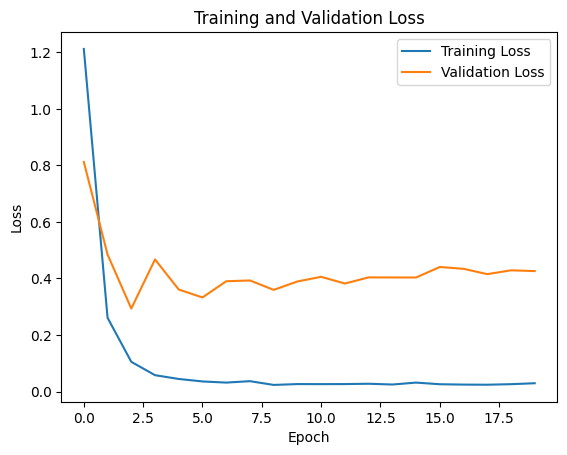

In [94]:
# Passo 3: Treinar o modelo
history = model.fit(trainX, trainY,
                    validation_data=(valX, valY),
                    epochs=best_params['epochs'],
                    batch_size=best_params['batch_size'],
                    verbose=1)
#model.fit(trainX, trainY, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=1)

import matplotlib.pyplot as plt

plt.figure(facecolor='white')
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Agora o modelo está treinado com os melhores parâmetros encontrados pelo Optuna

In [95]:
# Now let's predict and compare with original dataset
# Scale the parameters for the forecast period and also for the original ones

# get the original data for the forecast period
df_original = differentiated_df.iloc[-forecast_period:,:]
#scale it
old_scaled_array=scaler.transform(df_original)

# scale test dataset parameters
new_scaled_array=scaler.transform(df_test)
new_scaled_df=pd.DataFrame(new_scaled_array) # convert in dataframe

# Concatenate both dataframes
full_df=pd.concat([pd.DataFrame(old_scaled_array),new_scaled_df]).reset_index().drop(["index"],axis=1)

# Convert to a numpy array
full_df_scaled_array=full_df.values

# Prediction
all_data = []
time_step = forecast_period
# Iterate thought
for i in range(time_step, len(full_df_scaled_array)):
    data_x = []
    data_x.append(full_df_scaled_array[i-time_step: i, 0:full_df_scaled_array.shape[1]])
    data_x = np.array(data_x, dtype=np.float32)
    prediction = model.predict(data_x)
    all_data.append(prediction)
    full_df.iloc[i, 0] = prediction

1/1 [==============================] - 0s 65ms/step


In [96]:
# Reverse the scale for predictions
# convert the prediction to a numpy array
new_array=np.array(all_data)
# reshape the array to only one column
new_array=new_array.reshape(-1,1)
# repeat the array to have the same shape as the test set - repeat df_test.shape[1] times - Only to get the correct shape
prediction_copies_array = np.repeat(new_array,df_test.shape[1], axis=-1)
# inverse transform the prediction - reverse the scaling
y_pred_future_months_diff = scaler.inverse_transform(np.reshape(prediction_copies_array,(len(new_array),df_test.shape[1])))
# reverse the differenciation. For that, we transform the prediction to a dataframe and use the function to reverse the differenciation
y_pred_future_months = uf.test_stationarity_and_differenciate(
    pd.DataFrame(y_pred_future_months_diff, index=df_test.index),
    reverse = True, diff_dict = diff_dict_to_reverse).iloc[:,0]

KeyError: 'ECO_fiscal_result_month'

In [45]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Let's compute the RMSE and MAE between the prediction and the original value for the test set
df_check = df_raw[-forecast_period:].copy()

# Mean Absolute error

#mae_array = np.abs(y_pred_future_30_days, df_check.iloc[:,0])
#mae_mean = np.mean(mae_array)
mae = mean_absolute_error(y_pred_future_months, df_check.iloc[:,0])
print(f'Mean absolute error: {mae}')

# calculate RMSE
rmse = sqrt(mean_squared_error(y_pred_future_months, df_check.iloc[:,0]))
print('Test RMSE: %.3f' % rmse)

Mean absolute error: 25992.396484375
Test RMSE: 31119.886


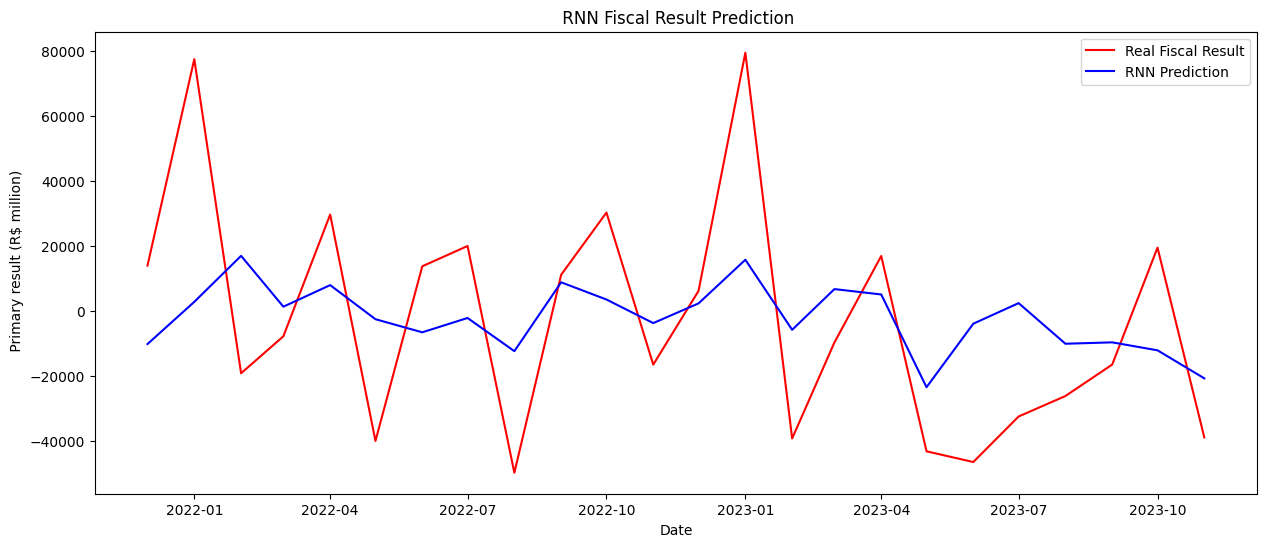

In [46]:
# Let's plot the results

#df_for_testing.index = pd.to_datetime(df_for_testing.index)

plt.figure(figsize=(15, 6))
plt.plot(df_test.index, df_check.iloc[:,0], color = 'red', label = 'Real Fiscal Result')
plt.plot(df_test.index, y_pred_future_months, color = 'blue', label = 'RNN Prediction')

plt.title(' RNN Fiscal Result Prediction')
plt.xlabel('Date')
plt.ylabel(' Primary result (R$ million)')
plt.legend()



plt.show()

In [47]:
stop

NameError: name 'stop' is not defined

In [ ]:
# # Evaluate with grid!
# grid_search = grid_search.fit(trainX, trainY)

# #These are the best parameters
# grid_search.best_params_

# # This is my best model

# my_model = grid_search.best_estimator_

# # Let's predict
# prediction = my_model.predict(valX)

In [ ]:
# Let's reescale

# convert the prediction to a numpy array and reshape to only one column
new_array=np.array(prediction).reshape(-1,1)
# repeat the array to have the same shape as the val set - repeat valX.shape[2] times - Only to get the correct shape
prediction_copies_array = np.repeat(new_array,valX.shape[2], axis=-1)
# inverse transform the prediction - reverse the scaling
pred_diff = scaler.inverse_transform(np.reshape(prediction_copies_array,(len(prediction),valX.shape[2])))
# reverse the differenciation. For that, we transform the prediction to a dataframe and use the function to reverse the differenciation
pred = uf.test_stationarity_and_differenciate(
    pd.DataFrame(pred_diff, index=df_for_validation.index[:-n_past]), # transform the prediction to a dataframe using the index of the original df
    reverse = True, diff_dict = diff_dict_to_reverse).iloc[:,0] #iloc[:,0] to get the first column
#pred = scaler.inverse_transform(np.reshape(prediction_copies_array,(len(prediction),testX.shape[2])))[:,0]


In [ ]:
# Let's get the original values
# Repeat the original values to have the same shape as the validation set
original_copies_array = np.repeat(valY,valX.shape[2], axis=-1)
# inverse transform the original values - reverse the scaling
original_diff=scaler.inverse_transform(np.reshape(original_copies_array,(len(valY),valX.shape[2])))
# reverse the differenciation. For that, we transform the original values to a dataframe and use the function to reverse the differenciation
original=uf.test_stationarity_and_differenciate(
    pd.DataFrame(original_diff, index=df_for_validation.index[:-n_past]), # transform the original values to a dataframe using the index of the original df
    reverse = True, diff_dict = diff_dict_to_reverse).iloc[:,0] #iloc[:,0] to get the first column

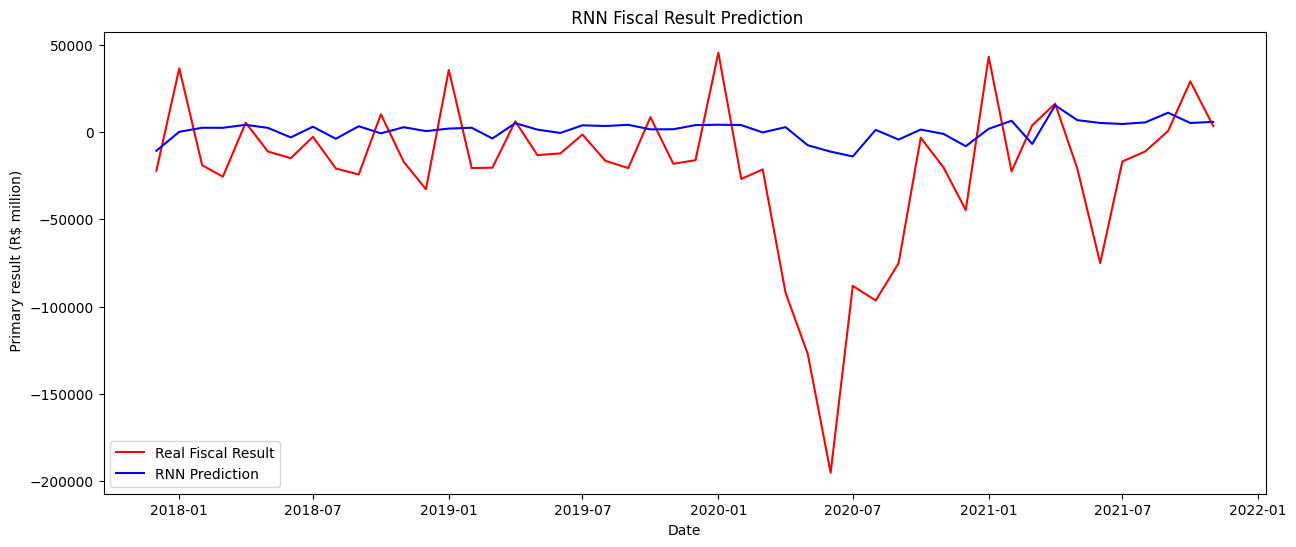

In [ ]:
# Let's plot the results

df_for_validation.index = pd.to_datetime(df_for_validation.index)

plt.figure(figsize=(15, 6))
plt.plot(df_for_validation.index[-(split_rate-n_past):], original, color = 'red', label = 'Real Fiscal Result')
plt.plot(df_for_validation.index[-(split_rate-n_past):], pred, color = 'blue', label = 'RNN Prediction')

plt.title(' RNN Fiscal Result Prediction')
plt.xlabel('Date')
plt.ylabel(' Primary result (R$ million)')
plt.legend()

# Formating X-axis
#plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))


plt.show()

Compara reseultado com o test - calculando erro

In [ ]:
from sklearn.metrics import mean_absolute_error

# Let's compute the error between the prediction and the original value for the test set

mae = mean_absolute_error(original, pred)

# Mean error
print(f'Mean error: {mae}')

Mean error: 31165.517578125


In [ ]:
from sklearn.metrics import mean_squared_error

# Let's compute the RMSE between the prediction and the original value for the test set
# calculate RMSE
rmse = sqrt(mean_squared_error(original, pred))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 46388.512


In [ ]:
# Now let's predict next 30 days

# We had already defined this future 30 days
df_test.shape


(24, 119)

In [ ]:
# Scale the past 30 days and the parameters for the next 30 days

df_original = df.iloc[-forecast_period:,:]
old_scaled_array=scaler.transform(df_original)
new_scaled_array=scaler.transform(df_test)
new_scaled_df=pd.DataFrame(new_scaled_array)
full_df=pd.concat([pd.DataFrame(old_scaled_array),new_scaled_df]).reset_index().drop(["index"],axis=1)

full_df_scaled_array=full_df.values


all_data = []
time_step = forecast_period
for i in range(time_step, len(full_df_scaled_array)):
    data_x = []
    data_x.append(full_df_scaled_array[i-time_step: i, 0:full_df_scaled_array.shape[1]])
    data_x = np.array(data_x, dtype=np.float32)
    prediction = my_model.predict(data_x)
    all_data.append(prediction)
    full_df.iloc[i, 0] = prediction


In [ ]:
full_df_scaled_array=full_df.values

In [ ]:
all_data = []
time_step = forecast_period
for i in range(time_step, len(full_df_scaled_array)):
    data_x = []
    data_x.append(full_df_scaled_array[i-time_step: i, 0:full_df_scaled_array.shape[1]])
    data_x = np.array(data_x, dtype=np.float32)
    prediction = my_model.predict(data_x)
    all_data.append(prediction)
    full_df.iloc[i, 0] = prediction

In [ ]:
df_test.index

DatetimeIndex(['2021-12-01', '2022-01-01', '2022-02-01', '2022-03-01',
               '2022-04-01', '2022-05-01', '2022-06-01', '2022-07-01',
               '2022-08-01', '2022-09-01', '2022-10-01', '2022-11-01',
               '2022-12-01', '2023-01-01', '2023-02-01', '2023-03-01',
               '2023-04-01', '2023-05-01', '2023-06-01', '2023-07-01',
               '2023-08-01', '2023-09-01', '2023-10-01', '2023-11-01'],
              dtype='datetime64[ns]', name='date', freq=None)

In [ ]:
# Reverse the scale for predictions
# convert the prediction to a numpy array
new_array=np.array(all_data)
# reshape the array to only one column
new_array=new_array.reshape(-1,1)
# repeat the array to have the same shape as the test set - repeat df_test.shape[1] times - Only to get the correct shape
prediction_copies_array = np.repeat(new_array,df_test.shape[1], axis=-1)
# inverse transform the prediction - reverse the scaling
y_pred_future_months_diff = scaler.inverse_transform(np.reshape(prediction_copies_array,(len(new_array),df_test.shape[1])))
# reverse the differenciation. For that, we transform the prediction to a dataframe and use the function to reverse the differenciation
y_pred_future_months = uf.test_stationarity_and_differenciate(
    pd.DataFrame(y_pred_future_months_diff, index=df_test.index),
    reverse = True, diff_dict = diff_dict_to_reverse).iloc[:,0]


In [ ]:
from sklearn.metrics import mean_squared_error

# Let's compute the RMSE and MAE between the prediction and the original value for the test set
df_check = df_raw[-forecast_period:].copy()

# Mean Absolute error

#mae_array = np.abs(y_pred_future_30_days, df_check.iloc[:,0])
#mae_mean = np.mean(mae_array)
mae = mean_absolute_error(y_pred_future_months, df_check.iloc[:,0])
print(f'Mean absolute error: {mae}')

# calculate RMSE
rmse = sqrt(mean_squared_error(y_pred_future_months, df_check.iloc[:,0]))
print('Test RMSE: %.3f' % rmse)

Mean absolute error: 27561.564453125
Test RMSE: 33365.137


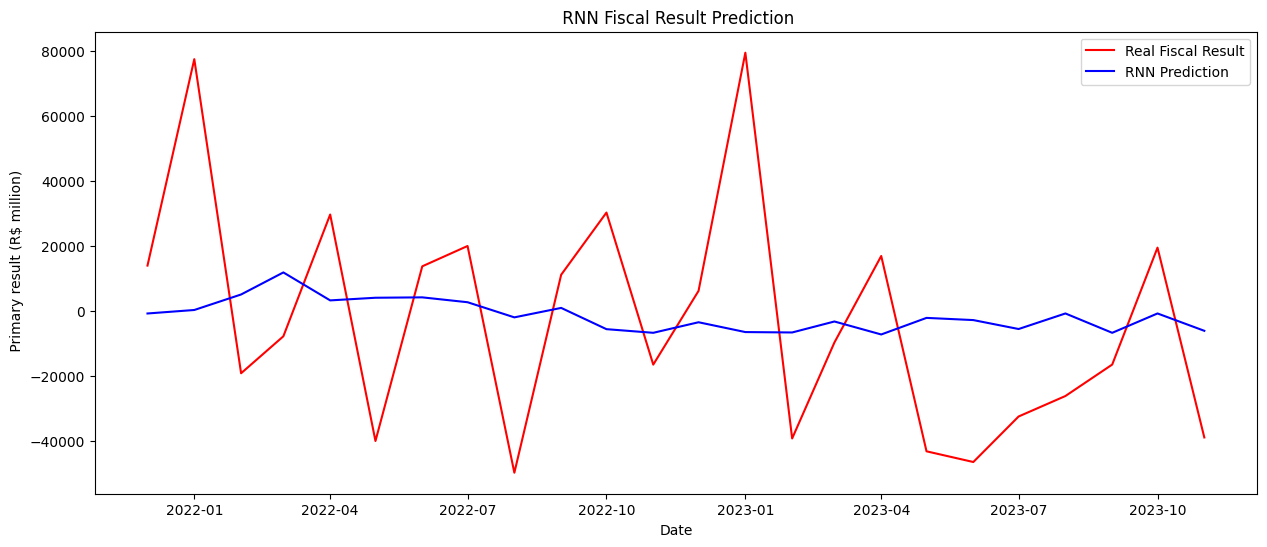

In [ ]:
# Let's plot the results

#df_for_testing.index = pd.to_datetime(df_for_testing.index)

plt.figure(figsize=(15, 6))
plt.plot(df_test.index, df_check.iloc[:,0], color = 'red', label = 'Real Fiscal Result')
plt.plot(df_test.index, y_pred_future_months, color = 'blue', label = 'RNN Prediction')

plt.title(' RNN Fiscal Result Prediction')
plt.xlabel('Date')
plt.ylabel(' Primary result (R$ million)')
plt.legend()



plt.show()

In [ ]:
# TODO: Ajustar o codigo abaixo para iterar sobre o modelo e a validação para encontrar os melhor CVs e drpout.

# Define the range of values for cv and dropout
cv_values = [5, 10, 15]
dropout_values = [0.1, 0.2, 0.3]

# Initialize variables to store the best results
best_rmse = float('inf')
best_mae = float('inf')
best_cv = None
best_dropout = None

# Initialize a dictionary to store the results for each combination of cv and dropout
results = {}

# Iterate over the cv and dropout values
for cv in cv_values:
    for dropout in dropout_values:
        # Build your model with the current cv and dropout values
        model = build_model(cv, dropout)
        
        # Train your model and make predictions on the validation set
        model.fit(trainX, trainY)
        prediction = model.predict(valX)
        
        # Compute the RMSE and MAE for the current iteration
        rmse = sqrt(mean_squared_error(valY, prediction))
        mae = mean_absolute_error(valY, prediction)
        
        # Store the results for the current combination of cv and dropout
        results[(cv, dropout)] = {'rmse': rmse, 'mae': mae}
        
        # Check if the current iteration has better results than the previous best
        if rmse < best_rmse:
            best_rmse = rmse
            best_mae = mae
            best_cv = cv
            best_dropout = dropout

# Print the best results and the corresponding cv and dropout values
print(f'Best RMSE: {best_rmse}')
print(f'Best MAE: {best_mae}')
print(f'Best cv: {best_cv}')
print(f'Best dropout: {best_dropout}')

# Print the results for each combination of cv and dropout
for (cv, dropout), result in results.items():
    print(f'CV: {cv}, Dropout: {dropout}, RMSE: {result["rmse"]}, MAE: {result["mae"]}')


TypeError: build_model() takes from 0 to 1 positional arguments but 2 were given